# EN ESTA NOTEBOOK SE IMPLEMENTARÁ UNA REGRESION LOGISTICA QUE CLASIFIQUE Y SE EVALUARÁN LOS RESULTADOS PARA EL PROYECTO


In [74]:
#importamos librerías

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score, confusion_matrix 


In [75]:
# IMPORTACIÓN DEL DATASET REDUCIDO LUEGO DEL PROCESAMIENTO DE COLUMNAS

df = pd.read_csv('friesgo_2018_reduc.csv',  sep=',', encoding='utf-8')

In [76]:
#muevo columnas de variables dependiendtes (enfermedades) al final

columnas_alFinal = [ 'dijeron_diabetes','veces_presion_alta', 'colesterol_alto']

df = df[[col for col in df if col not in columnas_alFinal] + columnas_alFinal]

print (df.iloc[:,-3:]) 

       dijeron_diabetes  veces_presion_alta  colesterol_alto
0                     0                   0                0
1                     0                   0                1
2                     0                   0                0
3                     0                   0                1
4                     0                   0                0
...                 ...                 ...              ...
25632                 0                   0                0
25633                 0                   1                1
25634                 0                   1                1
25635                 1                   0                0
25636                 1                   1                0

[25637 rows x 3 columns]


In [77]:
#escalado a todo menos a regiones para entrega 3
#scaler = StandardScaler()
#columna_no_escalar = df['region']
#columnas_a_escalar = df.drop(columns=['region'])
#columnas_escaladas = scaler.fit_transform(columnas_a_escalar)
#df_escalado = pd.DataFrame(columnas_escaladas, columns=columnas_a_escalar.columns)

#df= pd.concat([df_escalado, columna_no_escalar], axis=1)

In [78]:
# Lista de las regiones que se encuentran en el dataset

regiones = df['region'].unique()
print(regiones)

[1 2 3 4 5 6]


In [79]:
# Crear un diccionario para almacenar los DataFrames por región

dfs_por_region = {}

In [80]:
# Iterar sobre cada región y guardar un nuevo DF por cada una

for region in regiones:
    # Filtrar los datos por la región actual
    df_region = df[df['region'] == region]
    # Guardar el DataFrame en el diccionario usando la región como clave
    dfs_por_region[region] = df_region

In [81]:

#funcion para calcular metricas por cada región y para cada enfermedad

def metricas(y_pred, y_test, enfermedad, region_actual):
        global resultados_por_region
        exactitud = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        sensibilidad = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        confusion = confusion_matrix(y_test, y_pred)

        # Inicializar las claves si no existen
        if enfermedad not in resultados_por_region:
            resultados_por_region[enfermedad] = {}
        if region_actual not in resultados_por_region[enfermedad]:
            resultados_por_region[enfermedad][region_actual] = {}
        
        
        resultados_por_region[enfermedad][region_actual]={
            'exactitud':exactitud,
            'precision':precision,
            'sensibilidad':sensibilidad,
            'f1': f1,
            'confusion': confusion
        }
        
        
        

In [82]:
# Crear diccionarios para almacenar modelos y resultados por región
modelos_por_region = {}
resultados_por_region = {}
importancia_por_region = {}



# Iterar sobre cada región para entrenar y evaluar modelos
for region in regiones:
    # Obtener el DataFrame de la región actual
    df_region = dfs_por_region[region]
    
    # Variables independientes
    X_region = df_region.iloc[:, 1:-3]  # Todas las columnas menos las últimas tres y la primera (id)
    
    # Variables dependientes
    y_region_colesterol = df_region['colesterol_alto']
    y_region_diabetes = df_region['dijeron_diabetes']
    y_region_hipertension = df_region['veces_presion_alta']

    
    #ESCALAR VARIABLES PARA UNIFICAR PESOS EN REGRESION LINEAL
    scaler = StandardScaler()
    X_region_escalada = scaler.fit_transform(X_region)
    
    
    
    
    # Dividir los datos en conjuntos de entrenamiento y prueba para cada enfermedad
    X_train_col, X_test_col, y_train_col, y_test_col = train_test_split(X_region_escalada, y_region_colesterol, test_size=0.25, random_state=0)
    X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(X_region_escalada, y_region_diabetes, test_size=0.25, random_state=0)
    X_train_hip, X_test_hip, y_train_hip, y_test_hip = train_test_split(X_region_escalada, y_region_hipertension, test_size=0.25, random_state=0)
    
    # Crear y entrenar el modelo para cada enfermedad
    clf_col = LogisticRegression(random_state=0, max_iter=1000)
    clf_col.fit(X_train_col, y_train_col)
    
    
   
    clf_dia = LogisticRegression(random_state=0, max_iter=1000)
    clf_dia.fit(X_train_dia, y_train_dia)
   
    
    
    clf_hip = LogisticRegression(random_state=0, max_iter=1000)
    clf_hip.fit(X_train_hip, y_train_hip)
    

  
    # Almacenar los modelos y sus resultados por región
    modelos_por_region[region] = {
        'colesterol': clf_col,
        'diabetes': clf_dia,
        'hipertension': clf_hip
    }

         
    #obtener los coeficienter de las caracteristicas
    coef_col = clf_col.coef_[0]
    coef_dia = clf_dia.coef_[0]
    coef_hip = clf_hip.coef_[0]
    
    
    #almacenamos la importancia de cada caracteristica
    importancia_por_region[region]={
        'colesterol': coef_col,
        'diabetes': coef_dia,
        'hipertension': coef_hip  
    }
      
        
    # Probar modelo con conjunto de prueba
    y_pred_col = clf_col.predict(X_test_col)
    y_pred_dia = clf_dia.predict(X_test_dia)
    y_pred_hip = clf_hip.predict(X_test_hip)
    
   
    
    
    ## METRICAS DE EVALUACIÓN   ##############33
    metricas(y_pred_col, y_test_col, 'colesterol', region)
    metricas(y_pred_dia, y_test_dia, 'diabetes', region)
    metricas(y_pred_hip, y_test_hip, 'hipertension', region)
    
    
print("finalizado")

finalizado


  ## CÁLCULOS DE EXACTITUD, PRECISIÓN, SENSIBILIDAD, F1-Score Y MATRIZ DE CONFUSIÓN POR CADA ENFERMEDAD Y POR CADA REGIÓN 

In [83]:
region_dict = {
    1: 'Metropolitana',
    2: 'Pampeana',
    3: 'Noroeste',
    4: 'Noreste',
    5: 'Cuyo',
    6: 'Patagónica'
}


In [84]:
# Mostrar los resultados por enfermedad y por región

for enfermedad, regiones in resultados_por_region.items():
    for region, resultados in regiones.items():

        nombre_region = region_dict.get(region, f"Región {region}")
        print(f"Enfermedad: {enfermedad}")
        print(f"Región: {nombre_region}")
        print(f"Exactitud del modelo: {resultados['exactitud']:.4f}")
        print(f"Precision del modelo: {resultados['precision']:.4f}")
        print(f"Sensibilidad del modelo: {resultados['sensibilidad']:.4f}")
        print(f"f1 del modelo: {resultados['f1']:.4f}")
        print(f"Matriz de confusion del modelo: \n{resultados['confusion']}\n")

        
        

Enfermedad: colesterol
Región: Metropolitana
Exactitud del modelo: 0.7136
Precision del modelo: 0.6596
Sensibilidad del modelo: 0.7136
f1 del modelo: 0.6679
Matriz de confusion del modelo: 
[[542  53]
 [179  36]]

Enfermedad: colesterol
Región: Pampeana
Exactitud del modelo: 0.7919
Precision del modelo: 0.7427
Sensibilidad del modelo: 0.7919
f1 del modelo: 0.7275
Matriz de confusion del modelo: 
[[1603   34]
 [ 397   37]]

Enfermedad: colesterol
Región: Noroeste
Exactitud del modelo: 0.7931
Precision del modelo: 0.7541
Sensibilidad del modelo: 0.7931
f1 del modelo: 0.7546
Matriz de confusion del modelo: 
[[876  45]
 [196  48]]

Enfermedad: colesterol
Región: Noreste
Exactitud del modelo: 0.8102
Precision del modelo: 0.7696
Sensibilidad del modelo: 0.8102
f1 del modelo: 0.7593
Matriz de confusion del modelo: 
[[691  18]
 [149  22]]

Enfermedad: colesterol
Región: Cuyo
Exactitud del modelo: 0.7368
Precision del modelo: 0.6965
Sensibilidad del modelo: 0.7368
f1 del modelo: 0.6913
Matriz d

## Conclusiones de análisis de los modelos:

<u>RESPECTO A COLESTEROL<u>
    
Las metricas son similares o un poco mejor a las obtenidad en el algoritmo de arboles de decision mejorado con GridSearch. 
Las regiones 1 y 5 (metropolitana y cuyo) son las que tienen peor desempeño, tal vez relacionado con el hecho de que son las de menor número de filas.
    
<u>RESPECTO A DIABETES<u>
    
La mayoria de las regiones tienen metricas por encima de 0.8 lo que se considera un buen desempeño. Similar a lo que sucedía en arboles de decisión

<u>RESPECTO A HIPERTENSIÓN<u>
    
Los resultados no son tan buenos como las metricas de diabetes, sin embargo la precisión, exactitud, etc.. es mejor que en los arboles de decisión con hiperparámetros optimizados

 ## CALCULOS DE LA IMPORTANCIA DE CADA CARACTERÍSTICA ANALIZADA (VARIABLES INDEPENDIENTES) EN EL MODELO QUE PERMITE DETERMINAR LA EXISTENCIA O NO DE LAS ENFERMEDADES CONSIDERADAS (COLESTEROL, DIABETES E HIPERTENSIÓN) 

### CARACTERÍSTICAS MÁS IMPORTANTES EN LA DETERMINACIÓN DEL COLESTEROL SEPARADAS POR REGIÓN

In [85]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_colesterol_df = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])


for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_col = importancias['colesterol']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_col)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_col[i] > 0.20:  # solo imprimo columnas con importancia mayor a cierto valor
                                 
            print(f"{columnas_originales[i]}: {importances_col[i]:.4f}")
            
            importancias_colesterol_df = importancias_colesterol_df.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_col[i]     
            }, ignore_index=True)
            
    print("\n")    
    
    

Región: Metropolitana
edad: 0.5309
nivel_instruccion_7: 0.3430
actualmente_fuma_cigarrillos: 0.2966
nivel_instruccion_5: 0.2539
nivel_instruccion_3: 0.2269


Región: Pampeana
edad: 0.5490
peso_kg: 0.3151
nivel_instruccion_7: 0.2023


Región: Noroeste
edad: 0.5634
nivel_instruccion_6: 0.2648
nivel_instruccion_4: 0.2360


Región: Noreste
edad: 0.6773
ascociado_Obra_social: 0.2948
promedio_fv_diario: 0.2679
peso_kg: 0.2431
no_asociado_nada: 0.2326
asociado_plan_estatal: 0.2261
consumo_5porc_fv_2: 0.2139


Región: Cuyo
edad: 0.5441
peso_kg: 0.2705
baño_2: 0.2598
af_intensa_veces_por_semana: 0.2585
promedio_fv_diario: 0.2388
baño_1: 0.2257


Región: Patagónica
edad: 0.6693
considera_su_alimentacion_3: 0.2494
ascociado_Obra_social: 0.2014
considera_su_alimentacion_2: 0.2004




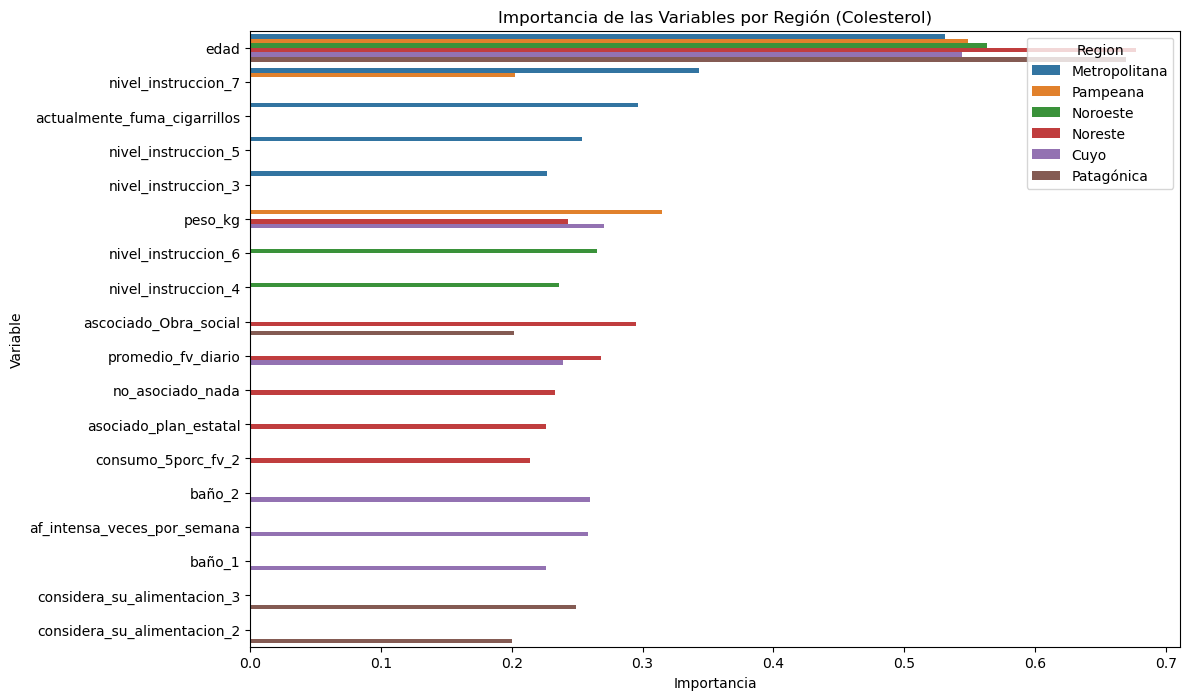

In [86]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_colesterol_df)
plt.title('Importancia de las Variables por Región (Colesterol)')
plt.show()

### Conclusiones: 

1. A partir del gráfico se puede inferir que hay más características importantes y además son más variadas entre zonas.
2. Se observa que el sobrepeso es común a todas las variables. 
3. No aparece la variable EDAD, tal vez sea un problema del ESCALADO?



### CARACTERÍSTICAS MÁS IMPORTANTES EN LA DETERMINACIÓN DE LA HIPERTENSIÓN SEPARADAS POR REGIÓN

In [87]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_hipertension_df = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])


for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_hip = importancias['hipertension']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_hip)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_hip[i] > 0.2:  # solo imprimo columnas con importancia mayor a 0
                    
            print(f"{columnas_originales[i]}: {importances_hip[i]:.4f}")
            
            importancias_hipertension_df = importancias_hipertension_df.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_hip[i]     
            }, ignore_index=True)
            
    print("\n") 


Región: Metropolitana
edad: 0.8537
baño_1: 0.6367
peso_kg: 0.5290
baño_3: 0.5171
baño_2: 0.4846
nivel_instruccion_6: 0.2977
nivel_instruccion_4: 0.2818
nivel_instruccion_5: 0.2429
sexo_2: 0.2379
nivel_instruccion_3: 0.2245
actualmente_fuma_cigarrillos: 0.2071


Región: Pampeana
edad: 0.8126
nivel_actividad_fisica_3: 0.5319
peso_kg: 0.4881
nivel_actividad_fisica_2: 0.4658
nivel_actividad_fisica_1: 0.3757


Región: Noroeste
edad: 0.7636
ascociado_Obra_social: 0.2836
sexo_2: 0.2730
peso_kg: 0.2346
no_asociado_nada: 0.2331
actualmente_fuma_cigarrillos: 0.2210


Región: Noreste
edad: 0.9360
nivel_instruccion_5: 0.4120
peso_kg: 0.3238
nivel_instruccion_4: 0.2993
nivel_instruccion_2: 0.2828
nivel_instruccion_3: 0.2587
nivel_instruccion_7: 0.2405
nivel_instruccion_6: 0.2117


Región: Cuyo
edad: 0.6097
peso_kg: 0.4372
ascociado_Obra_social: 0.4163
baño_1: 0.3907
no_asociado_nada: 0.3862
baño_2: 0.3261
actualmente_fuma_cigarrillos: 0.3113
asociado_prepaga_porObra_social: 0.2924
baño_3: 0.2766
se

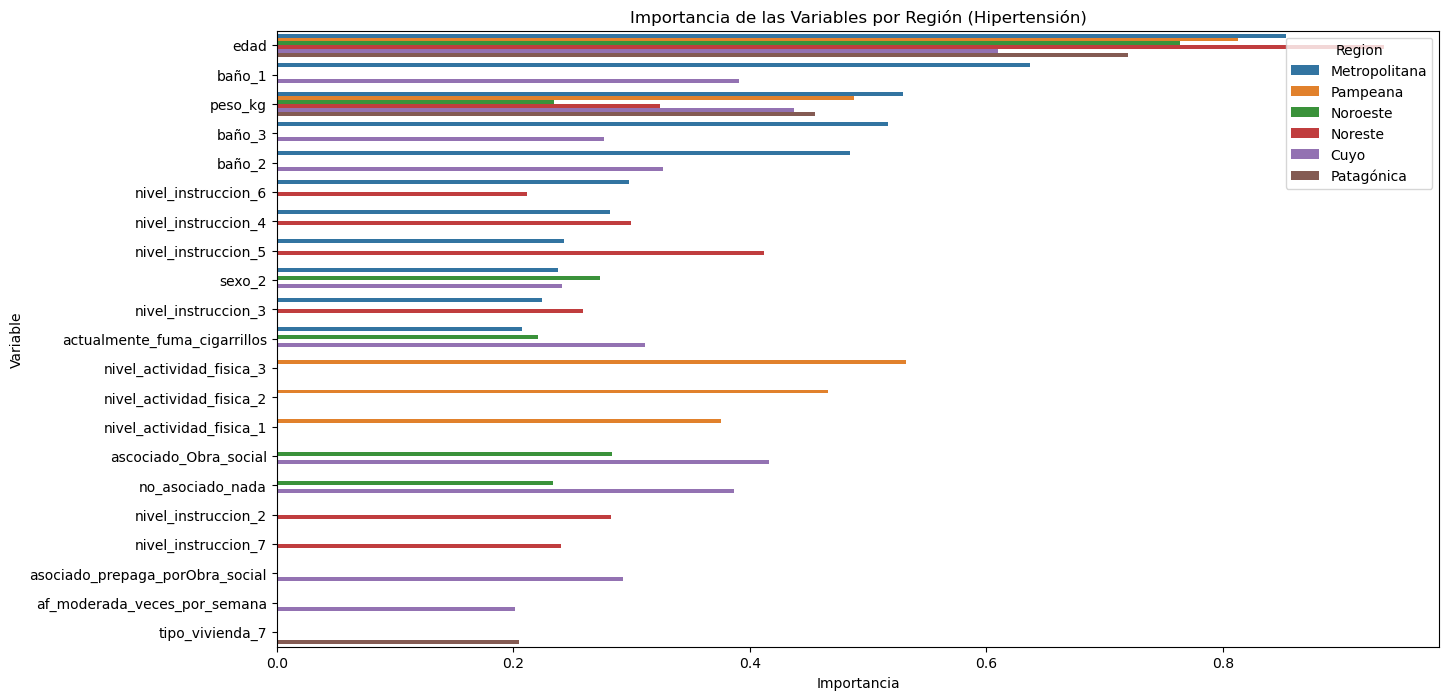

In [88]:

plt.figure(figsize=(15, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_hipertension_df)
plt.title('Importancia de las Variables por Región (Hipertensión)')
plt.show()

### Conclusiones causas Hipertensión
1. Nuevamente aparecen mayor cantidad de variables con importancia y más variadas
2. El sobrepeso es muy importante en noroeste y cuyo pero no en otras regiones
3. actividad fisica, nivel actividad, caminata, etc.. aparecen como acarcterístucas importantes en varias regiones pero con distintos nombres  (aunque hacen referencia a valores similares) 
4. En avrias regiones aparece como importante la altura. Se debería verificar que no es un problema de escalado

### CARACTERÍSTICAS MÁS IMPORTANTES EN LA DETERMINACIÓN DE LA DIABETES SEPARADAS POR REGIÓN

In [89]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_diabetes_df = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])

for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_dia = importancias['diabetes']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_dia)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
   
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_dia[i] > 0.2:  # solo imprimo columnas con importancia mayor a 0
            print(f"{columnas_originales[i]}: {importances_dia[i]:.4f}")
            
            importancias_diabetes_df = importancias_diabetes_df.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_dia[i]     
            }, ignore_index=True)
    print("\n")


Región: Metropolitana
edad: 0.6187
baño_1: 0.5312
baño_2: 0.4516
baño_3: 0.4505
actualmente_fuma_cigarrillos: 0.2735
peso_kg: 0.2472
consumo_5porc_fv_2: 0.2164


Región: Pampeana
edad: 0.3757
peso_kg: 0.3160
actualmente_fuma_cigarrillos: 0.2612
promedio_fv_diario: 0.2119


Región: Noroeste
actualmente_fuma_cigarrillos: 0.3549
edad: 0.2324
nivel_instruccion_4: 0.2196
alguna_vez_fumo: 0.2021


Región: Noreste
edad: 0.5066
actualmente_fuma_cigarrillos: 0.3802
af_moderada_min_totales_por_semana: 0.2966
situacion_conyugal_6: 0.2460


Región: Cuyo
edad: 0.5459
baño_1: 0.3299
asociado_prepaga_porObra_social: 0.2939
no_asociado_nada: 0.2916
baño_2: 0.2637
peso_kg: 0.2574
actualmente_fuma_cigarrillos: 0.2566
af_intensa_veces_por_semana: 0.2479
af_fue_actividad_laboral: 0.2431
nivel_actividad_fisica_3: 0.2415
cant_componentes: 0.2082


Región: Patagónica
edad: 0.4737
peso_kg: 0.3283
baño_1: 0.3269
baño_2: 0.2709
nivel_instruccion_4: 0.2254




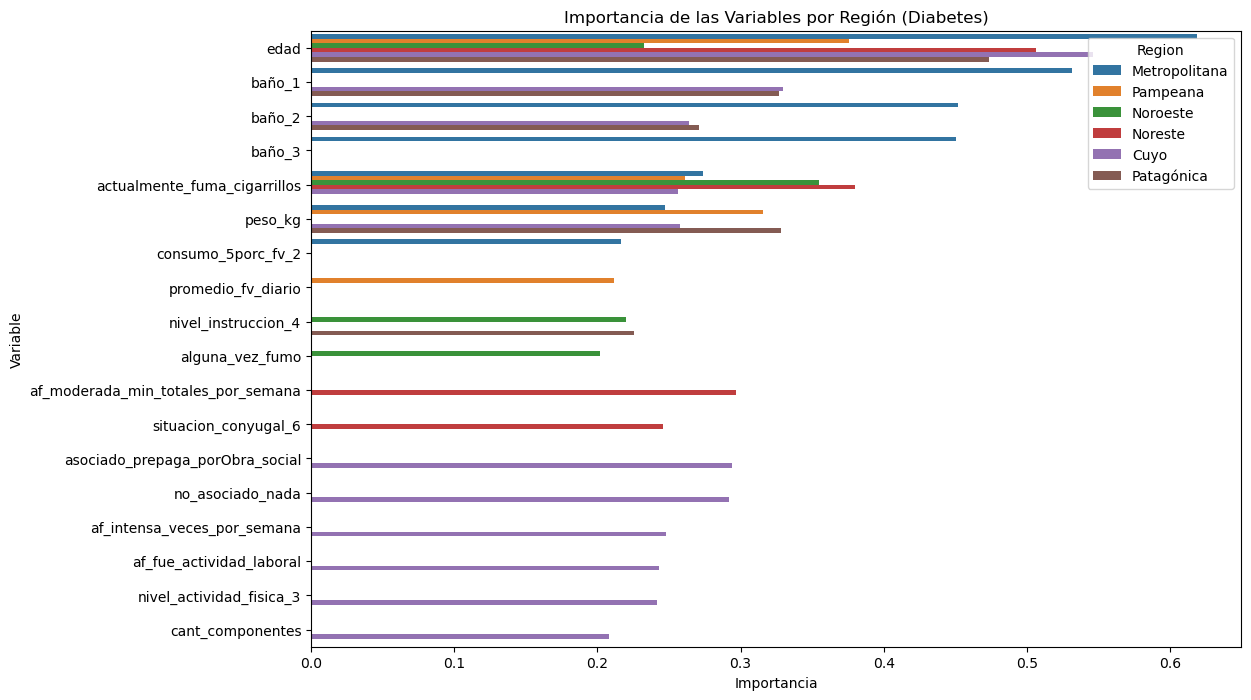

In [90]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_diabetes_df)
plt.title('Importancia de las Variables por Región (Diabetes)')
plt.show()

### Conclusiones causas Diabetes:
1. En este caso vuelve a aprecer la variable sobre peso
2. Valores de variables que indican o relacionados con la actividad física son importantes en varias regiones
3. Se ve una gran cantidad de variables importantes y muy distribuidas. 

# CONCLUSIONES GENERALES

1. En general se observa que la importancia de cada característica está más distribuída, ya que incluso considerando valores mayores a 0.1 siguen apareciendo varias características en todas las regiones y todas las enfermedades
2. Es llamativo que la variable edad no aparece prácticamente.

# APLICAMOS GRIDSEARCH PARA MEJORAR HIPERPARÁMETROS

In [91]:
#importamos librería
from sklearn.model_selection import GridSearchCV

from sklearn.exceptions import ConvergenceWarning
import warnings

In [92]:
#definimos grilla de hiperparámetros

param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Valor de regularización
    'solver': ['liblinear', 'lbfgs'],  # Solvers disponibles
    'max_iter': [100, 200]  # Número máximo de iteraciones
}

In [93]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [94]:
# Crear diccionarios para almacenar modelos y resultados por región
modelos_por_region = {}
resultados_por_region = {}
importancia_por_region = {}


# Crear diccionario para almacenar los resultados de GridSearch
#mejores_modelos_por_region = {}

# Iterar sobre cada región para entrenar y evaluar modelos
for region in regiones:
    # Obtener el DataFrame de la región actual
    df_region = dfs_por_region[region].sample(frac=0.1, random_state=0)  # Usar el 10% de los datos para prueba
    df_region = dfs_por_region[region]
    
    # Variables independientes
    X_region = df_region.iloc[:, 1:-3]  # Todas las columnas menos las últimas tres y la primera (id)
    
    # Variables dependientes
    y_region_colesterol = df_region['colesterol_alto']
    y_region_diabetes = df_region['dijeron_diabetes']
    y_region_hipertension = df_region['veces_presion_alta']

    
    #ESCALAR VARIABLES PARA UNIFICAR PESOS EN REGRESION LINEAL
    scaler = StandardScaler()
    X_region_escalada = scaler.fit_transform(X_region)
    if np.isnan(X_region_escalada).any() or np.isinf(X_region_escalada).any():
        print(f"Región {region} tiene valores NaN o infinitos después del escalado.")
    
    # Dividir los datos en conjuntos de entrenamiento y prueba para cada enfermedad
    X_train_col, X_test_col, y_train_col, y_test_col = train_test_split(X_region_escalada, y_region_colesterol, test_size=0.25, random_state=0)
    X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(X_region_escalada, y_region_diabetes, test_size=0.25, random_state=0)
    X_train_hip, X_test_hip, y_train_hip, y_test_hip = train_test_split(X_region_escalada, y_region_hipertension, test_size=0.25, random_state=0)
    
    
    #Definimos el modelo a utilizar
    modelo = LogisticRegression(random_state=0)
    
    # Crear y entrenar el modelo para cada enfermedad
    grid_search_col = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=3)
    grid_search_col.fit(X_train_col, y_train_col)
    mejor_modelo_col = grid_search_col.best_estimator_
    
   
    grid_search_dia = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=3)
    grid_search_dia.fit(X_train_dia, y_train_dia)
    mejor_modelo_dia = grid_search_dia.best_estimator_
    
    
    grid_search_hip = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=3)
    grid_search_hip.fit(X_train_hip, y_train_hip)
    mejor_modelo_hip = grid_search_hip.best_estimator_
    
    
    
    # Almacenar los mejores modelos y sus parámetros
#    mejores_modelos_por_region[region] = {
#        'colesterol': grid_search_col.best_estimator_,
#        'diabetes': grid_search_dia.best_estimator_,
#        'hipertension': grid_search_hip.best_estimator_,
#        'parametros_colesterol': grid_search_col.best_params_,
#        'parametros_diabetes': grid_search_dia.best_params_,
#        'parametros_hipertension': grid_search_hip.best_params_
#    }
  
    # Almacenar los modelos y sus resultados por región
    modelos_por_region[region] = {
        'colesterol': mejor_modelo_col,
        'diabetes': mejor_modelo_dia,
        'hipertension': importances_hip
    }


    # Imprimir los mejores parámetros encontrados
  #  print(f"Región: {region}")
  #  print(f"Mejores parámetros para colesterol: {grid_search_col.best_params_}")
  #  print(f"Mejores parámetros para diabetes: {mejor_modelo_dia.best_params_}")
  #  print(f"Mejores parámetros para hipertension: {grid_search_hip.best_params_}")


    
     
    #obtener los coeficienter de las caracteristicas
    coef_col = mejor_modelo_col.coef_[0]
    coef_dia = mejor_modelo_dia.coef_[0]
    coef_hip = mejor_modelo_hip.coef_[0]
    
    
    #almacenamos la importancia de cada caracteristica
    importancia_por_region[region]={
        'colesterol': coef_col,
        'diabetes': coef_dia,
        'hipertension': coef_hip  
    }
      
         
    
    
    # Evaluar modelos con el conjunto de prueba
    y_pred_col = grid_search_col.predict(X_test_col)
    y_pred_dia = grid_search_dia.predict(X_test_dia)
    y_pred_hip = grid_search_hip.predict(X_test_hip)
    
    
    ## METRICAS DE EVALUACIÓN   ##############33
    metricas(y_pred_col, y_test_col, 'colesterol', region)
    metricas(y_pred_dia, y_test_dia, 'diabetes', region)
    metricas(y_pred_hip, y_test_hip, 'hipertension', region)
    
    
print("finalizado")




Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each

In [95]:
# Mostrar los resultados por enfermedad y por región

for enfermedad, regiones in resultados_por_region.items():
    for region, resultados in regiones.items():

        nombre_region = region_dict.get(region, f"Región {region}")
        print(f"Enfermedad: {enfermedad}")
        print(f"Región: {nombre_region}")
        print(f"Exactitud del modelo: {resultados['exactitud']:.4f}")
        print(f"Precision del modelo: {resultados['precision']:.4f}")
        print(f"Sensibilidad del modelo: {resultados['sensibilidad']:.4f}")
        print(f"f1 del modelo: {resultados['f1']:.4f}")
        print(f"Matriz de confusion del modelo: \n{resultados['confusion']}\n")


Enfermedad: colesterol
Región: Metropolitana
Exactitud del modelo: 0.7136
Precision del modelo: 0.6617
Sensibilidad del modelo: 0.7136
f1 del modelo: 0.6702
Matriz de confusion del modelo: 
[[540  55]
 [177  38]]

Enfermedad: colesterol
Región: Pampeana
Exactitud del modelo: 0.7919
Precision del modelo: 0.7427
Sensibilidad del modelo: 0.7919
f1 del modelo: 0.7275
Matriz de confusion del modelo: 
[[1603   34]
 [ 397   37]]

Enfermedad: colesterol
Región: Noroeste
Exactitud del modelo: 0.7931
Precision del modelo: 0.7541
Sensibilidad del modelo: 0.7931
f1 del modelo: 0.7546
Matriz de confusion del modelo: 
[[876  45]
 [196  48]]

Enfermedad: colesterol
Región: Noreste
Exactitud del modelo: 0.8091
Precision del modelo: 0.7669
Sensibilidad del modelo: 0.8091
f1 del modelo: 0.7586
Matriz de confusion del modelo: 
[[690  19]
 [149  22]]

Enfermedad: colesterol
Región: Cuyo
Exactitud del modelo: 0.7301
Precision del modelo: 0.6857
Sensibilidad del modelo: 0.7301
f1 del modelo: 0.6849
Matriz d

## COnclusiones



## Parametros más importantes en el modelo con hiperparámetros mejorados para el colesterol

In [96]:
# Crear un DataFrame vacío para almacenar las importancias
importancias_colesterol_df_mejorado = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])


for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_col = importancias['colesterol']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_col)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_col[i] > 0.25:  # solo imprimo columnas con importancia mayor a 0
                                 
            print(f"{columnas_originales[i]}: {importances_col[i]:.4f}")
            
            importancias_colesterol_df_mejorado = importancias_colesterol_df_mejorado.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_col[i]     
            }, ignore_index=True)
            
    print("\n")    
    

Región: Metropolitana
edad: 0.5400
nivel_instruccion_7: 0.4531
nivel_instruccion_5: 0.3584
nivel_instruccion_3: 0.3125
actualmente_fuma_cigarrillos: 0.3001
nivel_instruccion_6: 0.2703
nivel_instruccion_4: 0.2618


Región: Pampeana
edad: 0.5485
peso_kg: 0.3150


Región: Noroeste
edad: 0.5687
nivel_instruccion_6: 0.3033
nivel_instruccion_4: 0.2742


Región: Noreste
edad: 0.6839
ascociado_Obra_social: 0.3236
promedio_fv_diario: 0.2712
no_asociado_nada: 0.2624


Región: Cuyo
baño_1: 0.7496
baño_2: 0.7308
edad: 0.5614
baño_3: 0.3618
af_intensa_veces_por_semana: 0.2749


Región: Patagónica
edad: 0.6784
considera_su_alimentacion_3: 0.2531




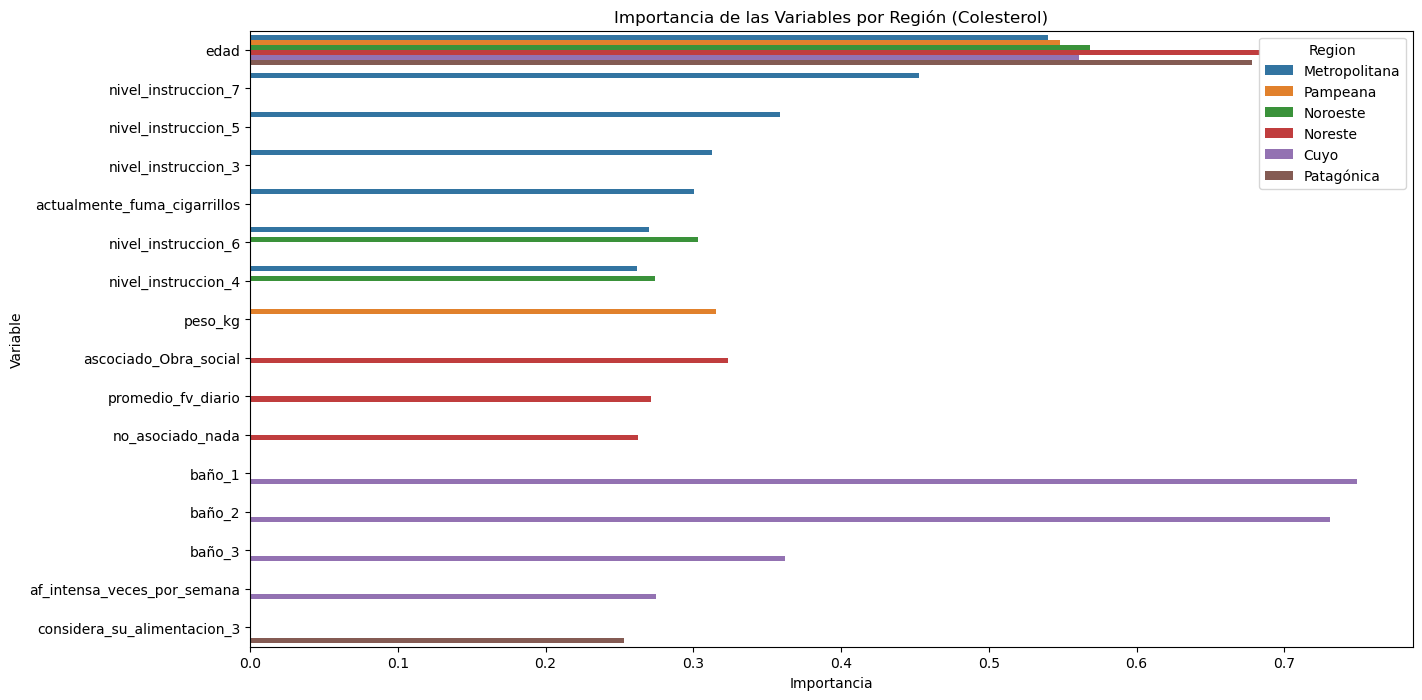

In [97]:

plt.figure(figsize=(15, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_colesterol_df_mejorado)
plt.title('Importancia de las Variables por Región (Colesterol)')
plt.show()

### Conclusiones

## Parametros más importantes en el modelo con hiperparámetros mejorados para la hipertensión


In [98]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_hipertension_df_mejorado = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])


for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_hip = importancias['hipertension']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_hip)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_hip[i] > 0.2:  # solo imprimo columnas con importancia mayor a 0
                    
            print(f"{columnas_originales[i]}: {importances_hip[i]:.4f}")
            
            importancias_hipertension_df_mejorado = importancias_hipertension_df_mejorado.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_hip[i]     
            }, ignore_index=True)
            
    print("\n") 


Región: Metropolitana
baño_1: 1.4092
baño_3: 1.1057
baño_2: 1.0763
edad: 0.8612
peso_kg: 0.5325
nivel_instruccion_6: 0.3563
nivel_instruccion_4: 0.3388
nivel_instruccion_5: 0.3107
nivel_instruccion_3: 0.2800
nivel_instruccion_7: 0.2584
sexo_2: 0.2392
actualmente_fuma_cigarrillos: 0.2091


Región: Pampeana
edad: 0.6510
peso_kg: 0.4216


Región: Noroeste
edad: 0.7673
ascociado_Obra_social: 0.2994
sexo_2: 0.2713
no_asociado_nada: 0.2502
peso_kg: 0.2227
actualmente_fuma_cigarrillos: 0.2210
tipo_vivienda_7: 0.2172


Región: Noreste
edad: 0.6156
peso_kg: 0.2503


Región: Cuyo
edad: 0.3935
peso_kg: 0.3440


Región: Patagónica
edad: 0.4801
peso_kg: 0.3428




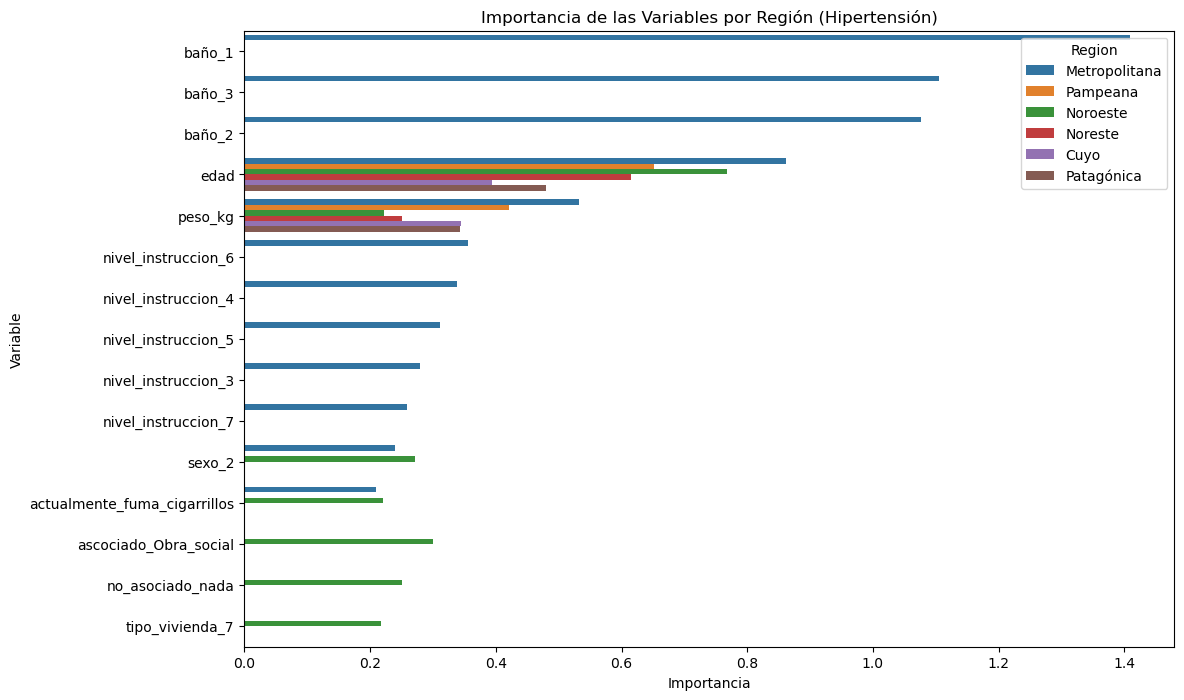

In [99]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_hipertension_df_mejorado)
plt.title('Importancia de las Variables por Región (Hipertensión)')
plt.show()

### Conclusiones


## Parametros más importantes en el modelo con hiperparámetros mejorados para la diabetes

In [100]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_diabetes_df_mejorado = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])

for region, importancias in importancia_por_region.items():
    # Obtener la importancia de diabetes de la región actual
    importances_dia = importancias['diabetes']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_dia)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
   
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_dia[i] > 0.25:  # solo imprimo columnas con importancia mayor a 0
            print(f"{columnas_originales[i]}: {importances_dia[i]:.4f}")
            
            importancias_diabetes_df_mejorado = importancias_diabetes_df_mejorado.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_dia[i]     
            }, ignore_index=True)
    print("\n")

Región: Metropolitana
baño_1: 1.3094
baño_2: 1.0498
baño_3: 1.0441
edad: 0.6254
actualmente_fuma_cigarrillos: 0.2829


Región: Pampeana
edad: 0.3743
peso_kg: 0.3161
actualmente_fuma_cigarrillos: 0.2606


Región: Noroeste
actualmente_fuma_cigarrillos: 0.3603
nivel_instruccion_4: 0.2563


Región: Noreste
edad: 0.5066
actualmente_fuma_cigarrillos: 0.3802
af_moderada_min_totales_por_semana: 0.2966


Región: Cuyo
baño_1: 0.9514
baño_2: 0.8234
edad: 0.5709
baño_3: 0.4608
no_asociado_nada: 0.3467
asociado_prepaga_porObra_social: 0.3242
af_intensa_veces_por_semana: 0.2736
ascociado_Obra_social: 0.2593
nivel_actividad_fisica_3: 0.2519


Región: Patagónica
edad: 0.4737
peso_kg: 0.3283
baño_1: 0.3269
baño_2: 0.2709




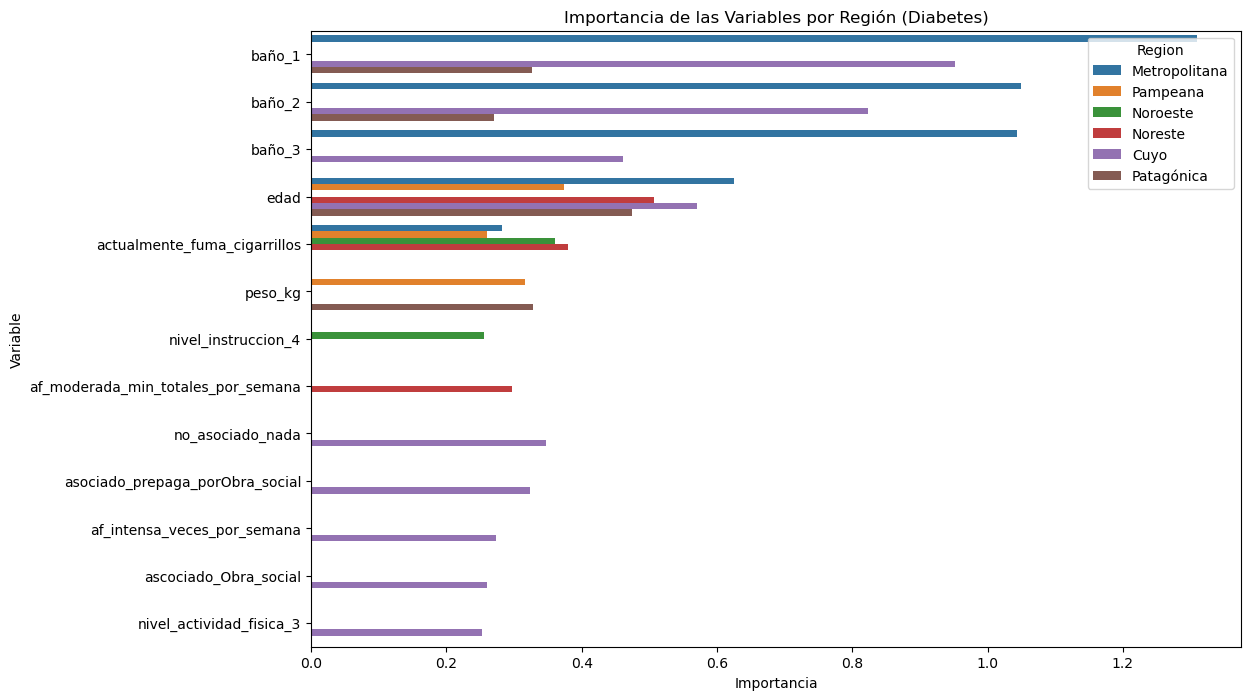

In [101]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_diabetes_df_mejorado)
plt.title('Importancia de las Variables por Región (Diabetes)')
plt.show()

### Conclusiones


# CONCLUSIONES GENERALES